## Part 2: Image Mosaics

In this part of the assignment, you will implement an image stitcher that uses image warping
and homographies to automatically create an image mosaic. We will focus on the case where
we have two input images that should form the mosaic, where we warp one image into the plane
of the second image and display the combined views. original input.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

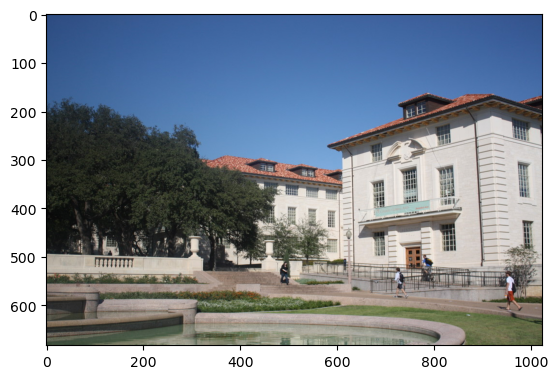

In [2]:
image1 = cv2.imread('image1.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
plt.imshow(image1)

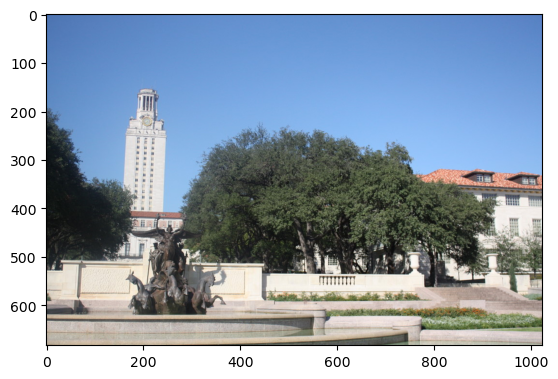

In [3]:
image2 = cv2.imread('image2.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.imshow(image2)

## 2.1 Getting Correspondences and Compute the Homography Parameters

The first steps of this part is the same as 1.1 and 1.2. We will follow the same steps to get the
correspondences and the homography matrix.

### Getting Correspondences

The first step is to find the correspondences between the two images. Use SIFT descriptor from
OpenCV library to find keypoints in each image and then use the brute force matcher from OpenCV
to get the correspondences. Use the matching way as KNN with size 2, and apply ratio checking 
between the best 2 matches to filter the good correspondences.

Choose 50 correspondences and plot the first image, the second image and the matches
as shown below.

In [4]:
def get_matches(image1, image2, max_matches=100, ratio_threshold=0.5):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_threshold*n.distance:
            good_matches.append(m)
            if len(good_matches) == max_matches:
                break
    
    return kp1, kp2, good_matches

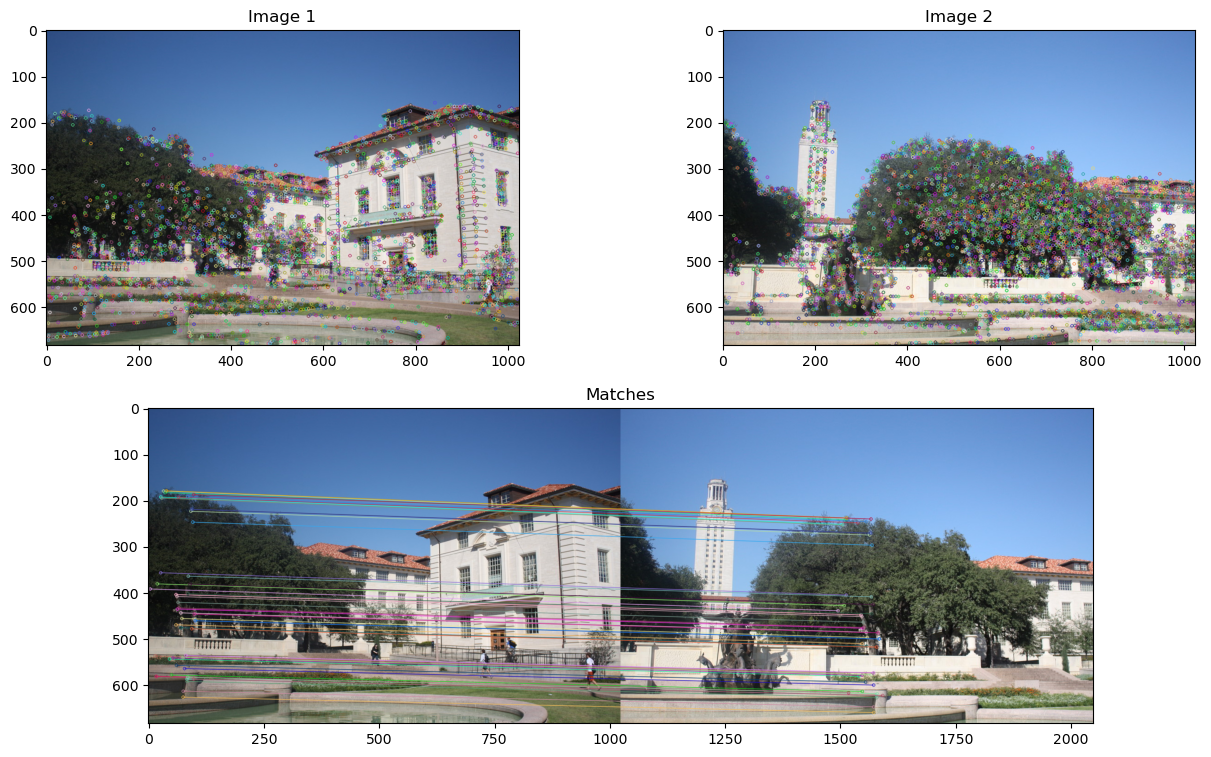

In [5]:
kp1, kp2, good_matches = get_matches(image1, image2)

# cv.drawMatchesKnn expects list of lists as matches.
good_list_of_lists = [[el] for el in good_matches]
image_matches = cv2.drawMatchesKnn(image1, kp1, 
                           image2, kp2, 
                           good_list_of_lists[:50], None, 
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

image1_kp = image1.copy()
image2_kp = image2.copy()

plt.figure(figsize=(16,9))

ax = plt.subplot(2, 2, 1)
ax.set_title("Image 1")
plt.imshow(cv2.drawKeypoints(image1_kp, kp1, image1_kp))

ax = plt.subplot(2, 2, 2)
ax.set_title("Image 2")
plt.imshow(cv2.drawKeypoints(image2_kp, kp2, image2_kp))

ax = plt.subplot(2, 2, (3,4))
ax.set_title("Matches")
plt.imshow(image_matches)

### Compute the Homography Parameters

Write a function that takes a set of corresponding image points and computes the associated
3×3 homography matrix H. This matrix transforms any point p in one view to its corresponding
homogeneous coordinates in the second view, p’, such that p’ = Hp. Note that p and p’ are both
3D points in homogeneous coordinates. The function should take a list of n >= 4 pairs of corresponding
points from the two views, where each point is specified with its 2D image coordinates.

We can set up a solution using a system of linear equations Ax = b, where the 8 unknowns
of H are stacked into an 8-vector x , the 2n-vector b contains image points from one view, and
the 2n × 8 matrix A is filled appropriately so that the full system gives us λp = Hp. There
are only 8 unknowns in H because we set H(3,3) = 1. Solve for the unknown homography matrix
parameters.

Verify that the homography matrix your function computes is correct by mapping the clicked
image points from one view to the other, and displaying them on top of each respective image.
Be sure to handle homogenous and non-homogenous coordinates correctly.

In [6]:
kp1_good = np.array([kp1[mat.queryIdx].pt for mat in good_matches], dtype=np.float32)
kp2_good = np.array([kp2[mat.trainIdx].pt for mat in good_matches], dtype=np.float32)

In [7]:
kp1_good[:5]

array([[  4.3550816, 391.925    ],
       [ 14.783103 , 537.2134   ],
       [ 17.552313 , 581.578    ],
       [ 17.552313 , 581.578    ],
       [ 19.82713  , 380.8795   ]], dtype=float32)

In [8]:
kp2_good[:5]

array([[470.7947 , 439.13068],
       [488.1206 , 575.07385],
       [493.95847, 617.054  ],
       [493.95847, 617.054  ],
       [484.05057, 428.06033]], dtype=float32)

In [9]:
kp_list = np.concatenate((kp1_good, kp2_good), axis=1)
len(kp_list)

100

In [10]:
def compute_homography_parameters(kp_list, n_pairs=4):
    # Dividing keypoint list to image 1 and image 2 keypoint lists
    kp1 = kp_list[:n_pairs, :2]
    kp2 = kp_list[:n_pairs, 2:]
    
    # Initialising matrices for calculations
    A = np.zeros((2*n_pairs, 9))
    B = kp2.reshape(-1)
    
    for i in range(n_pairs):
        # Extracting x, y, x', y' from keypoint list
        x = kp1[i][0]
        y = kp1[i][1]
        x_dash = kp2[i][0]
        y_dash = kp2[i][1]
        
        # X-coordinate row
        A[2*i][0] = x
        A[2*i][1] = y
        A[2*i][2] = 1
        A[2*i][6] = -x * x_dash
        A[2*i][7] = -y * x_dash
        A[2*i][8] = -x_dash
        
        # Y-coordinate row
        A[2*i+1][3] = x
        A[2*i+1][4] = y
        A[2*i+1][5] = 1
        A[2*i+1][6] = -x * y_dash
        A[2*i+1][7] = -y * y_dash
        A[2*i+1][8] = -y_dash

    _, s, vh = np.linalg.svd(A, full_matrices=True)
    X = vh[np.argmin(s)].reshape(3,3)
    X /= X[2,2]
    
    return X      

In [11]:
H = compute_homography_parameters(kp_list, n_pairs=100)
H

array([[ 7.52522218e-01,  4.36551756e-02,  4.45321040e+02],
       [-1.44548810e-01,  9.13513569e-01,  7.69266305e+01],
       [-2.33065007e-04, -2.48299953e-05,  1.00000000e+00]])

Inverse Homography Matrix

In [12]:
inv_H = np.linalg.inv(H)

In [13]:
kp1_good[:5]

array([[  4.3550816, 391.925    ],
       [ 14.783103 , 537.2134   ],
       [ 17.552313 , 581.578    ],
       [ 17.552313 , 581.578    ],
       [ 19.82713  , 380.8795   ]], dtype=float32)

In [14]:
kp2_good[:5]

array([[470.7947 , 439.13068],
       [488.1206 , 575.07385],
       [493.95847, 617.054  ],
       [493.95847, 617.054  ],
       [484.05057, 428.06033]], dtype=float32)

Using OpenCV's warpPerspective method to inspect effect of homography matrix

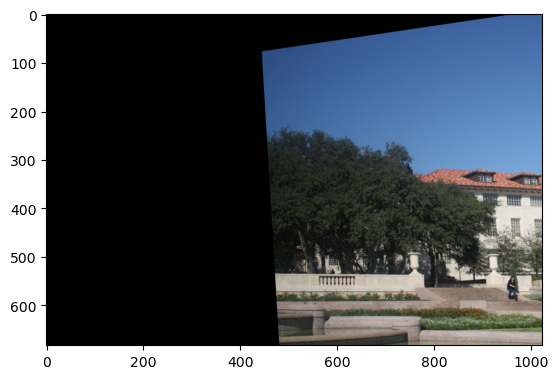

In [15]:
out = cv2.warpPerspective(image1, H, (image1.shape[1], image1.shape[0]))
plt.imshow(out)

Comparing against OpenCV's findHomography function

[[ 7.38652567e-01  4.38587144e-02  4.45421693e+02]
 [-1.50543642e-01  9.12174943e-01  7.72611943e+01]
 [-2.45389451e-04 -2.58672144e-05  1.00000000e+00]]


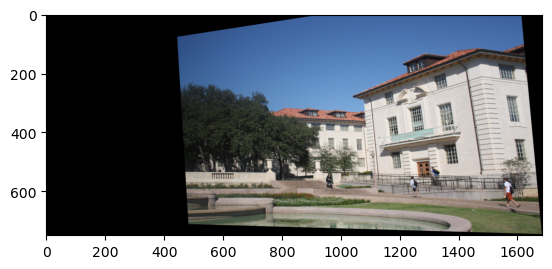

In [16]:
H_findHomography, _ = cv2.findHomography(kp1_good[:50], kp2_good[:50])
print(H_findHomography)
out_findHomography = cv2.warpPerspective(image1, H_findHomography, (1685, 750))
plt.imshow(out_findHomography)

**Verification**

In [17]:
# Converting keypoints of first image to their homogeneous representation
kp1_homo = np.array([el.T for el in kp1_good]).T
kp1_homo = np.vstack([kp1_homo, np.ones(kp1_homo.shape[1])])

# Calculating mapped points from first image keypoints and homography matrix
kp2_homo = np.dot(H, kp1_homo)
kp2_homo = np.delete(kp2_homo/kp2_homo[2], (2), axis=0).T

In [18]:
kp1_verify = [cv2.KeyPoint(int(np.round(kp[0])), int(np.round(kp[1])), 10) for kp in kp1_good]
kp2_verify = [cv2.KeyPoint(int(np.round(kp[0])), int(np.round(kp[1])), 10) for kp in kp2_homo]

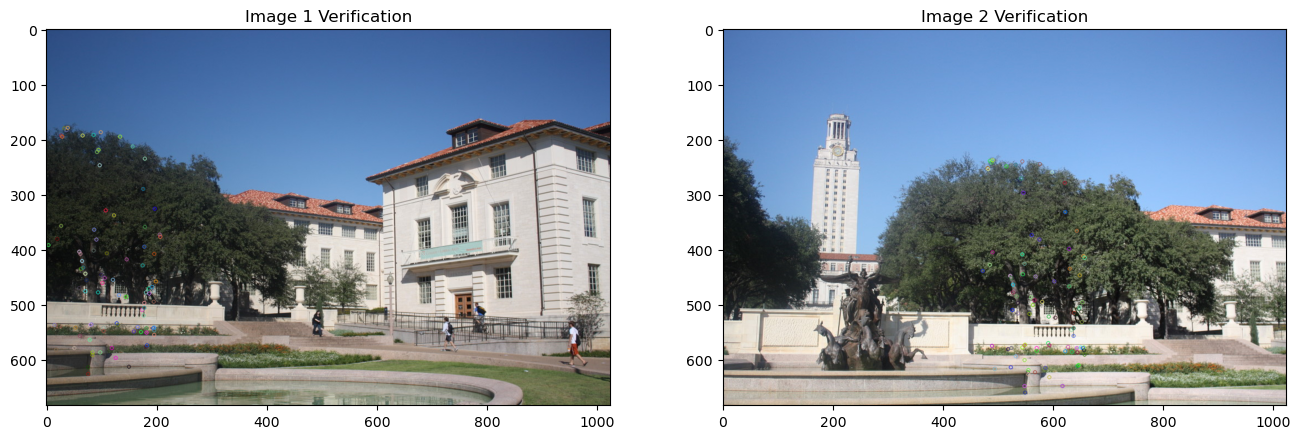

In [19]:
image1_verify = image1.copy()
image2_verify = image2.copy()

plt.figure(figsize=(16,9))

ax = plt.subplot(1, 2, 1)
ax.set_title("Image 1 Verification")
plt.imshow(cv2.drawKeypoints(image1_verify, kp1_verify, image1_verify))

ax = plt.subplot(1, 2, 2)
ax.set_title("Image 2 Verification")
plt.imshow(cv2.drawKeypoints(image2_verify, kp2_verify, image2_verify))

## 2.2 Warping Between Image Planes

Write a function that can take the recovered homography matrix and an image, and return a
new image that is the warp of the input image using H . Since the transformed coordinates
will typically be sub-pixel values, we can solve this by rounding the resulting coordinates or by
distributing the pixel value to the nearby destination pixels. For the later case the destination
pixel value is the average of any pixel values that maps to it. For color images, warp each RGB
channel separately and then stack together to form the output.

To avoid holes in the output, use an inverse warp. Warp the points from the source image
into the reference frame of the destination, and compute the bounding box in that new reference
frame. Then sample all points in that destination bounding box from the proper coordinates
in the source image (linear interpolation). Note that transforming all the points will generate
an image of a different shape/dimensions than the original input.

**Auxiliary Functions**

In [20]:
def homo(xy_tuple, H):
    x, y = xy_tuple
    input_px = np.array(([x], [y], [1]))
    output_px = H.dot(input_px)
    output_px /= output_px[2]
    return output_px[0], output_px[1]

In [21]:
def delete_black(image):
    # Deleting black rows
    idy = np.argwhere(np.all(image[..., :] == 0, axis=1))
    image = np.delete(image, idy, axis=0)
    # Deleting black columns
    idx = np.argwhere(np.all(image[..., :] == 0, axis=0))
    image = np.delete(image, idx, axis=1)
    return image

In [22]:
def get_subpixels(img, x, y):
    subpixels = [
        (int(np.floor(x)), int(np.floor(y))),
        (int(np.ceil(x)), int(np.floor(y))), 
        (int(np.floor(x)), int(np.ceil(y))), 
        (int(np.ceil(x)), int(np.ceil(y)))
    ]
    #print(subpixels)
    values = [
        img[subpixels[0][1]][subpixels[0][0]],
        img[subpixels[1][1]][subpixels[1][0]],
        img[subpixels[2][1]][subpixels[2][0]],
        img[subpixels[3][1]][subpixels[3][0]]
    ]
    
    subpixels = np.c_[subpixels, values]

    return np.array(subpixels).astype(int)

In [23]:
def bilinear_interpolation(x, y, subpixels):
    subpixels = sorted(subpixels)
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = subpixels

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('Points do not form rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within rectangle')

    return int(np.round((q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1))))

**Getting a bounding box to tightly fit warped image**

In [24]:
def get_bounding_box(img, H):
    min_x = np.inf
    min_y = np.inf
    max_x = np.NINF
    max_y = np.NINF
    src_to_dest_map = dict()
    height, width = img.shape[:2]
    for y_src in range(height):
        for x_src in range(width):
            x_dest, y_dest = homo((x_src, y_src), H)
            src_to_dest_map[x_src, y_src] = (x_dest, y_dest)
            min_x = int(min(min_x, x_dest))
            min_y = int(min(min_y, y_dest))
            max_x = int(max(max_x, x_dest))
            max_y = int(max(max_y, y_dest))
    return min_x, min_y, max_x, max_y, src_to_dest_map

**Forward & Inverse Warping Approach**

In [25]:
def warp_image(img, H):
    min_x, min_y, max_x, max_y, src_to_dest_map = get_bounding_box(img, H)
    #print(min_x, min_y, max_x, max_y)
    bounding_box = ((min_x, min_y), (max_x, max_y))
    warped_image = np.zeros((max_y - min_y + 2, max_x - min_x + 2, 3))
    accumulator = np.copy(warped_image)
    
    height, width = img.shape[:2]
    new_height, new_width = warped_image.shape[:2]
    
    for x_src in range(width):
        for y_src in range(height):
            x_dest, y_dest = src_to_dest_map[(x_src, y_src)]
            x_dest -= min_x
            y_dest -= min_y
            subpixels = get_subpixels(warped_image, x_dest, y_dest)[:,:2]
            for sp in range(len(subpixels)):
                for ch in range(3):
                    #print(subpixels)
                    warped_image[subpixels[sp][1]][subpixels[sp][0]][ch] += img[y_src][x_src][ch]
                    accumulator[subpixels[sp][1]][subpixels[sp][0]][ch] += 1
    # Averaging each value in warped image by value in accumulator        
    for x_dest in range(new_width):
        for y_dest in range(new_height):
            for ch in range(3):
                if warped_image[y_dest][x_dest][ch] > 0:
                    warped_image[y_dest][x_dest][ch] = int(np.round(warped_image[y_dest][x_dest][ch] / accumulator[y_dest][x_dest][ch]))
    
    return warped_image.astype(np.uint8), bounding_box

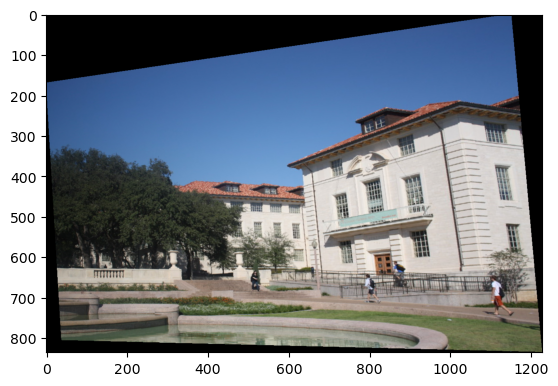

In [26]:
image1_warped, bounding_box = warp_image(image1, H)
plt.imshow(image1_warped)

In [27]:
def inv_warp_image(img, img_warped, bounding_box, H):
    height, width = img.shape[:2]
    new_height, new_width = img_warped.shape[:2]
    inv_H = np.linalg.inv(H)
    (min_x, min_y), (max_x, max_y) = bounding_box
    for x_dest in range(new_width):
        for y_dest in range(new_height):
            if (img_warped[y_dest][x_dest] == [0,0,0]).all():
                x_src, y_src = homo((x_dest, y_dest), inv_H)
                #x_src, y_src = int(np.round(x_src)), int(np.round(y_src))
                x_src += min_x
                y_src += min_y
                if x_src >= 0 and x_src < width and y_src >= 0 and y_src < height:
                    for ch in range(3):
                        #img_warped[y_dest][x_dest] = img[y_src][x_src]
                        img_warped[y_dest][x_dest][ch] = bilinear_interpolation(x_src, 
                                                                                y_src, 
                                                                                get_subpixels(img[:,:,ch], x_src, y_src))
    return img_warped.astype(np.uint8)

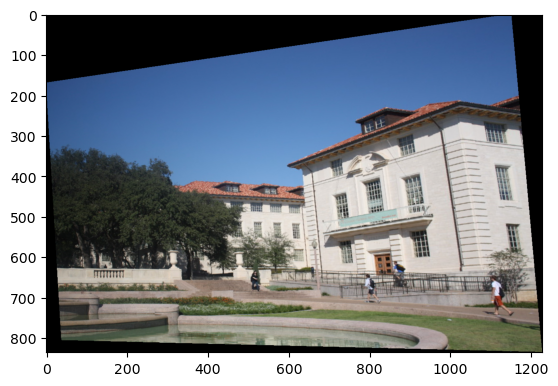

In [28]:
image1_warped = inv_warp_image(image1, image1_warped, bounding_box, H)
plt.imshow(image1_warped)

**Reverse Warping-only Approach**

In [29]:
def inv_warp_image_full(img, H):
    min_x, min_y, max_x, max_y, src_to_dest_map = get_bounding_box(img, H)
    bounding_box = ((min_x, min_y), (max_x, max_y))
    img_warped = np.zeros((max_y - min_y + 2, max_x - min_x + 2, 3))
    
    height, width = img.shape[:2]
    new_height, new_width = img_warped.shape[:2]
    inv_H = np.linalg.inv(H)
    
    for x_dest in range(new_width):
        for y_dest in range(new_height):
            if (img_warped[y_dest][x_dest] == [0,0,0]).all():
                x_src, y_src = homo((x_dest, y_dest), inv_H)
                x_src, y_src = int(np.round(x_src)), int(np.round(y_src))
                x_src += min_x
                y_src += min_y
                if x_src >= 0 and x_src < width and y_src >= 0 and y_src < height:
                    img_warped[y_dest][x_dest] = img[y_src][x_src]
    
    img_warped = delete_black(img_warped)
    
    return img_warped.astype(np.uint8)

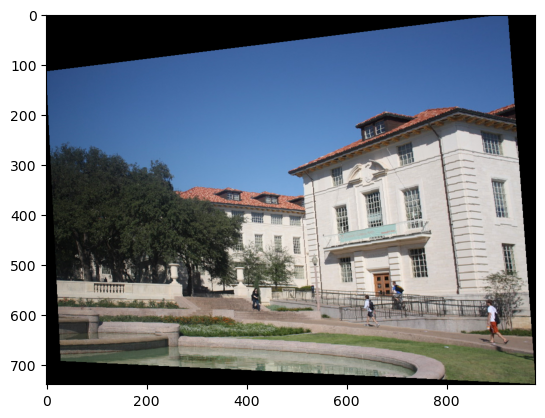

In [30]:
image1_warped_inv_warp_only = inv_warp_image_full(image1, H)
plt.imshow(image1_warped_inv_warp_only)

## 2.3 Create the output mosaic

Once we have the source image warped into the destination images frame of reference, we can
create a merged image showing the mosaic. Create a new image large enough to hold both
(registered) views; overlay one view onto the other, simply leaving it black wherever no data is
available. Do not worry about artifacts that result at the boundaries.

In [31]:
def stitch_images(image1_warped, image2, bounding_box):
    new_height, new_width = image1_warped.shape[:2]
    height2, width2 = image2.shape[:2]
    x_shift = -bounding_box[0][0]
    y_shift = -bounding_box[0][1]
    
    image_full = np.zeros(((new_height + height2), (new_width + width2), 3))
    image_full[0:image1_warped.shape[0], 0:image1_warped.shape[1]] = image1_warped
    
    for y in range(height2):
        for x in range(width2):
            x_new, y_new = x + x_shift , y + y_shift
            image_full[y_new][x_new] = image2[y][x]
    
    if x_shift < 0:
        image_full = np.roll(image_full, -x_shift, axis=1)
    if y_shift < 0:
        image_full = np.roll(image_full, -y_shift, axis=0)
    
    image_full = delete_black(image_full)
    
    return image_full.astype(np.uint8)

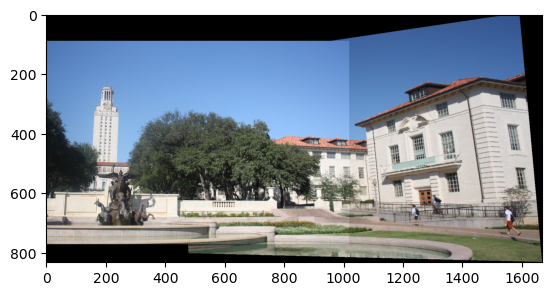

In [32]:
image_full = stitch_images(image1_warped, image2, bounding_box)
cv2.imwrite('image_full.jpg', cv2.cvtColor(image_full, cv2.COLOR_RGB2BGR))
plt.imshow(image_full)

In [33]:
def image_mosaics_pipeline(image1, image2):
    kp1, kp2, good_matches = get_matches(image1, image2)
    kp1_good = np.array([kp1[mat.queryIdx].pt for mat in good_matches], dtype=np.float32)
    kp2_good = np.array([kp2[mat.trainIdx].pt for mat in good_matches], dtype=np.float32)
    kp_list = np.concatenate((kp1_good, kp2_good), axis=1)
    H = compute_homography_parameters(kp_list, n_pairs=50)
    plt.imshow(cv2.warpPerspective(image1, H, (image1.shape[1], image1.shape[0])))
    image1_warped, bounding_box = warp_image(image1, H)
    image_full = stitch_images(image1_warped, image2, bounding_box)
    return image_full

## 3 Bonus

Instead of stitching 2 images, stitch 3 images that overlap with each other.

• Stitch 2 images together following the previous steps.

• Get correspondences between the output of stitching the 2 first images and the third image. Note: The order of stitc.

• Stitch the output with the third image creating the final output .

Note: The order of stitching yields different results.

(683, 1024, 3)

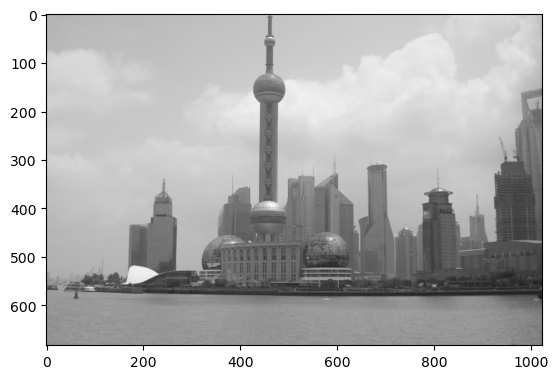

In [34]:
s_image1 = cv2.imread('shanghai-21.png')
s_image1 = cv2.cvtColor(s_image1, cv2.COLOR_BGR2RGB)
plt.imshow(s_image1)
s_image1.shape

(683, 1024, 3)

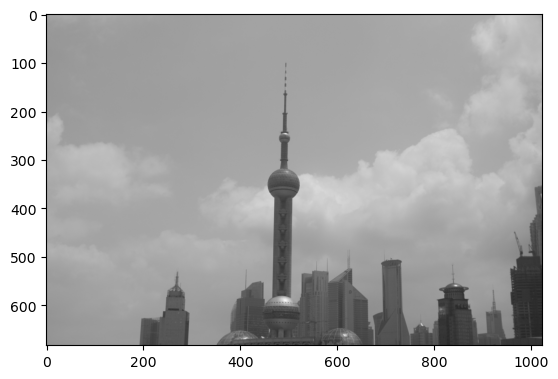

In [35]:
s_image2 = cv2.imread('shanghai-22.png')
s_image2 = cv2.cvtColor(s_image2, cv2.COLOR_BGR2RGB)
plt.imshow(s_image2)
s_image2.shape

(683, 1024, 3)

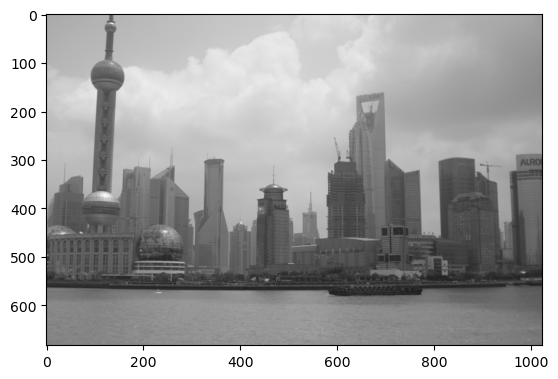

In [36]:
s_image3 = cv2.imread('shanghai-23.png')
s_image3 = cv2.cvtColor(s_image3, cv2.COLOR_BGR2RGB)
plt.imshow(s_image3)
s_image3.shape

### Stitching first two images together

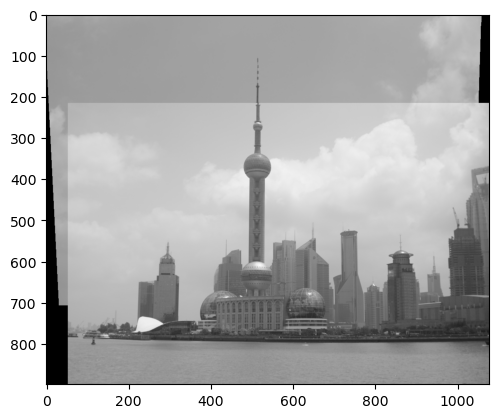

In [37]:
#image_mosaics_pipeline(s_image2, s_image1)
s_image_full_2of3 = image_mosaics_pipeline(s_image2, s_image1)
plt.imshow(s_image_full_2of3)

### Getting correspondences between first two stitched images and third image

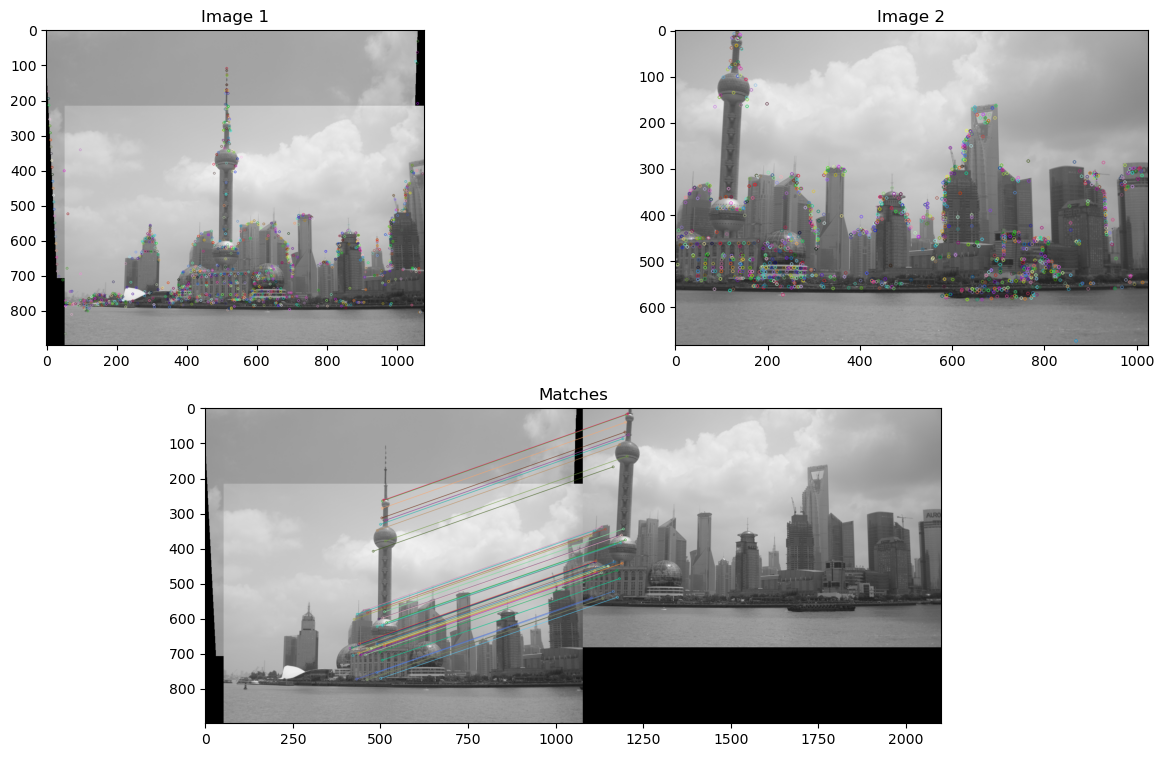

In [38]:
s_kp1, s_kp2, s_good_matches = get_matches(s_image_full_2of3, s_image3)

# cv.drawMatchesKnn expects list of lists as matches.
s_good_list_of_lists = [[el] for el in s_good_matches]
s_image_matches = cv2.drawMatchesKnn(s_image_full_2of3, s_kp1, 
                           s_image3, s_kp2, 
                           s_good_list_of_lists[:50], None, 
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

s_image1_kp = s_image_full_2of3.copy()
s_image2_kp = s_image3.copy()

plt.figure(figsize=(16,9))

ax = plt.subplot(2, 2, 1)
ax.set_title("Image 1")
plt.imshow(cv2.drawKeypoints(s_image1_kp, s_kp1, s_image1_kp))

ax = plt.subplot(2, 2, 2)
ax.set_title("Image 2")
plt.imshow(cv2.drawKeypoints(s_image2_kp, s_kp2, s_image2_kp))

ax = plt.subplot(2, 2, (3,4))
ax.set_title("Matches")
plt.imshow(s_image_matches)

### Stitching output with third image to create final output

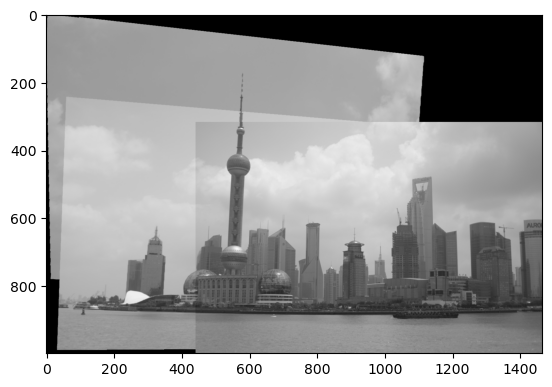

In [39]:
s_image_full = image_mosaics_pipeline(s_image_full_2of3, s_image3)
cv2.imwrite('shanghai-2_full.png', cv2.cvtColor(s_image_full, cv2.COLOR_RGB2BGR))
plt.imshow(s_image_full)